In [101]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchinfo import summary
import mlflow
import mlflow.pytorch


In [102]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    # else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)


# torch.set_default_device(device)
device

device(type='cpu')

# Load train data

In [103]:
train_dir = "Data/train"

image_size = (224, 224)


train_transform = transforms.Compose(
    [
        transforms.Resize(image_size),  # Resize to target size
        # transforms.RandomHorizontalFlip(),         # Augmentation: Random horizontal flip
        # transforms.RandomRotation(10),             # Augmentation: Random rotation up to 10 degrees
        transforms.ToTensor(),  # Convert image to tensor
    ]
)


train_data = ImageFolder(train_dir, transform=train_transform)
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

train_data

Dataset ImageFolder
    Number of datapoints: 1156
    Root location: Data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

# Load Test data

In [104]:
test_dir = "Data/test"
test_transform = transforms.Compose(
    [
        transforms.Resize(image_size),  # Resize to target size
        transforms.ToTensor(),  # Convert image to tensor
    ]
)

test_data = ImageFolder(test_dir, transform=test_transform)

test_data

Dataset ImageFolder
    Number of datapoints: 502
    Root location: Data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [105]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
print(f"Class names: {class_names}")

Number of training samples: 1156
Number of test samples: 502
Class names: ['Ajwa', 'Galaxy', 'Mejdool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


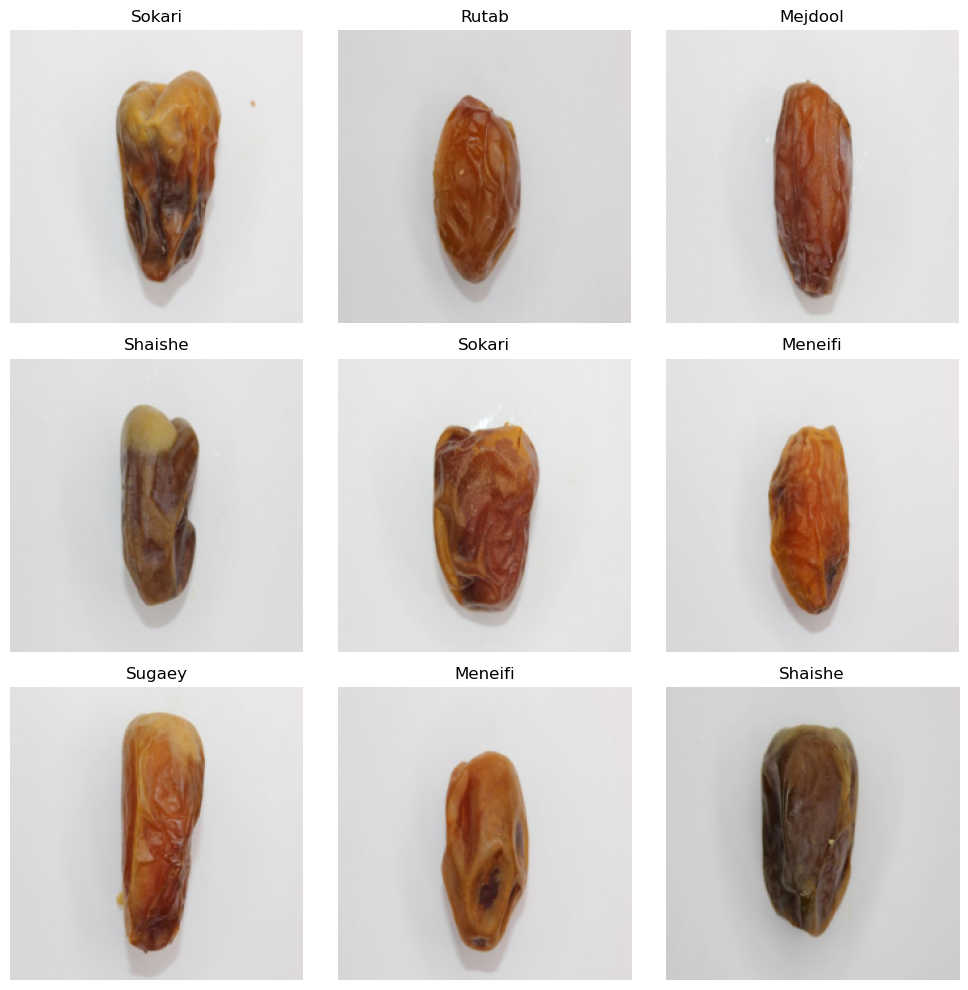

In [106]:
fig = plt.figure(figsize=(10, 10))

row, col = 3, 3

for i in range(9):
    ax = fig.add_subplot(row, col, i + 1)
    random_idx = torch.randint(low=0, high=len(test_data), size=[1]).item()
    img, label = test_data[random_idx]

    ax.imshow(
        img.permute(1, 2, 0),
    )
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

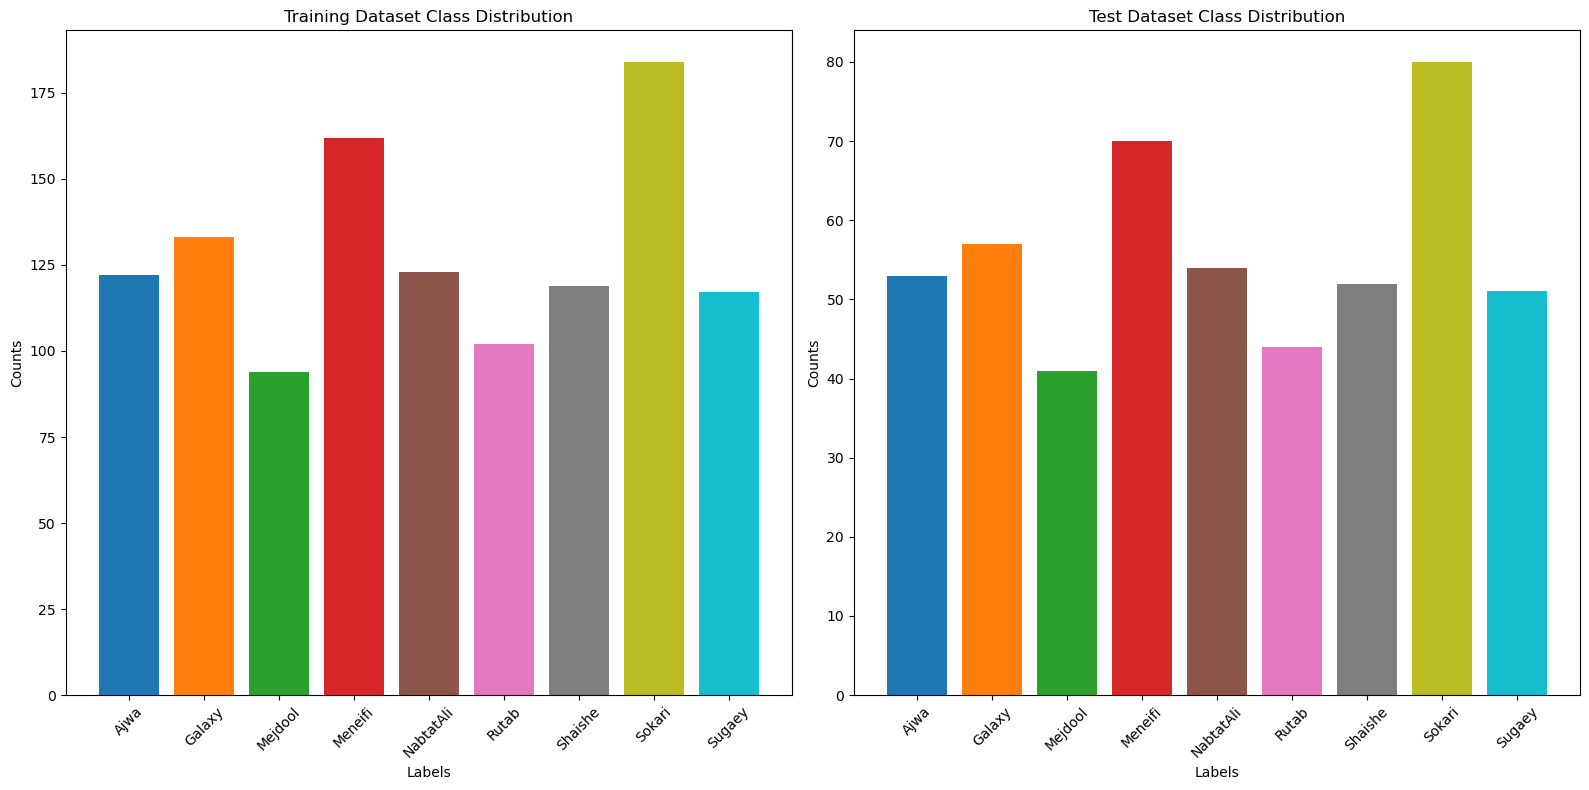

In [107]:
train_count_dir = dict(Counter(train_data.targets))
train_count_dir = {class_names[key]: value for key, value in train_count_dir.items()}

test_count_dir = dict(Counter(test_data.targets))
test_count_dir = {class_names[key]: value for key, value in test_count_dir.items()}

colors = plt.cm.tab10(np.linspace(0, 1, len(train_count_dir)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Training dataset plot
ax1.bar(list(train_count_dir.keys()), list(train_count_dir.values()), color=colors)
ax1.set_xlabel("Labels")
ax1.set_ylabel("Counts")
ax1.set_title("Training Dataset Class Distribution")
ax1.tick_params(axis="x", rotation=45)

# Test dataset plot
ax2.bar(list(test_count_dir.keys()), list(test_count_dir.values()), color=colors)
ax2.set_xlabel("Labels")
ax2.set_ylabel("Counts")
ax2.set_title("Test Dataset Class Distribution")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [108]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64

generator = torch.Generator(device=device) if device.type == "mps" else None


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, generator=generator)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, generator=generator)

In [109]:
class Date_Custom_CNN(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,  # how big is the square that's going over the image?
                stride=1,  # default
                padding=0,
            ),  # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units * 53 * 53, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
       
        x = self.conv_block_1(x)
       
        x = self.conv_block_2(x)
     
        x = self.classifier(x)
       
        return x

In [110]:
model = Date_Custom_CNN(input_shape=3, hidden_units=20, output_shape=len(class_names)).to(device)
# model(torch.randn(1, 3, 224, 224))
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Date_Custom_CNN                          [1, 9]                    --
├─Sequential: 1-1                        [1, 20, 110, 110]         --
│    └─Conv2d: 2-1                       [1, 20, 222, 222]         560
│    └─ReLU: 2-2                         [1, 20, 222, 222]         --
│    └─Conv2d: 2-3                       [1, 20, 220, 220]         3,620
│    └─ReLU: 2-4                         [1, 20, 220, 220]         --
│    └─MaxPool2d: 2-5                    [1, 20, 110, 110]         --
├─Sequential: 1-2                        [1, 20, 53, 53]           --
│    └─Conv2d: 2-6                       [1, 20, 108, 108]         3,620
│    └─ReLU: 2-7                         [1, 20, 108, 108]         --
│    └─Conv2d: 2-8                       [1, 20, 106, 106]         3,620
│    └─ReLU: 2-9                         [1, 20, 106, 106]         --
│    └─MaxPool2d: 2-10                   [1, 20, 53, 53]           --
├─Seq

# Set Up an MLflow Experiment

In [ ]:
# import mlflow
# mlflow.set_tracking_uri("file:///Users/ahmedalkhulayfi/Desktop/Date-Fruit-Image-Classification/")
# mlflow.set_experiment("Date_Classification")

MlflowException: Invalid experiment ID: '.git'

In [ ]:
def plot_training_curves(results):
    # Plot for accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(results["train_acc"], label='Train Accuracy')
    plt.plot(results["test_acc"], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Testing Accuracy over Epochs')
    plt.legend()
    plt.savefig("accuracy_curve.png")
    plt.close()
    mlflow.log_artifact("accuracy_curve.png")
    
    # Plot for loss
    plt.figure(figsize=(10, 5))
    plt.plot(results["train_loss"], label='Train Loss')
    plt.plot(results["test_loss"], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss over Epochs')
    plt.legend()
    plt.savefig("loss_curve.png")
    plt.close()
    mlflow.log_artifact("loss_curve.png")
    
from sklearn.metrics import confusion_matrix
import seaborn as sns

def log_confusion_matrix(model, dataloader, device, class_names):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.close()
    mlflow.log_artifact('confusion_matrix.png')



In [ ]:
import torch

# import mlflow
from tqdm.auto import tqdm
from torch import nn


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):

    model.train()

    train_loss, train_acc = 0, 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            test_preds = model(X)

            loss = loss_fn(test_preds, y)
            test_loss += loss.item()

            test_pred_labels = test_preds.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def training(
    model: torch.nn.Module,
    train_dataloader,
    test_dataloader,
    optimizer,
    device: torch.device,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    checkpoint_path: str = 'best_model.pth',
    run_name: str = "Run"
    
):
    with mlflow.start_run(run_name=run_name):
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("learning_rate", optimizer.param_groups[0]['lr'])
        mlflow.log_param("batch_size", train_dataloader.batch_size)
        mlflow.log_param("optimizer", optimizer.__class__.__name__)
        mlflow.log_param("loss_function", loss_fn.__class__.__name__)
        mlflow.log_param("model_architecture", model.__class__.__name__)
        
        # If using a custom model, log its summary
        model_summary = summary(model, input_size=(1, 3, 224, 224), verbose=0)
        
        with open("model_summary.txt", "w") as f:
            f.write(str(model_summary))
        mlflow.log_artifact("model_summary.txt")
        
        
        
        
        results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
        
        best_acc = 0.0
        
        
        
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = train_step(
                model=model,
                dataloader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,)
            test_loss, test_acc = test_step(
                model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device
            )

            print(
                f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}"
            )
            
            mlflow.log_metric("train_loss", train_loss, step=epoch+1)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch+1)
            mlflow.log_metric("test_loss", test_loss, step=epoch+1)
            mlflow.log_metric("test_accuracy", test_acc, step=epoch+1)
            
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)

            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(test_loss)
            results["test_acc"].append(test_acc)
            
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(model.state_dict(), checkpoint_path)
                
        plot_training_curves(results)
        mlflow.log_artifact("loss_curve.png")   
        mlflow.log_artifact("accuracy_curve.png")   
        
        log_confusion_matrix(model, test_dataloader, device, class_names)
        mlflow.log_artifact('confusion_matrix.png') 
                
        model.load_state_dict(torch.load(checkpoint_path))

        return results

In [ ]:

EPOCHS = 1

LR = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

# Ensure the model is on the correct device
model.to(device)

results = training(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device,
)


Exception: Invalid parent directory '/Users/ahmedalkhulayfi/Desktop/Date-Fruit-Image-Classification/mlruns/.trash'

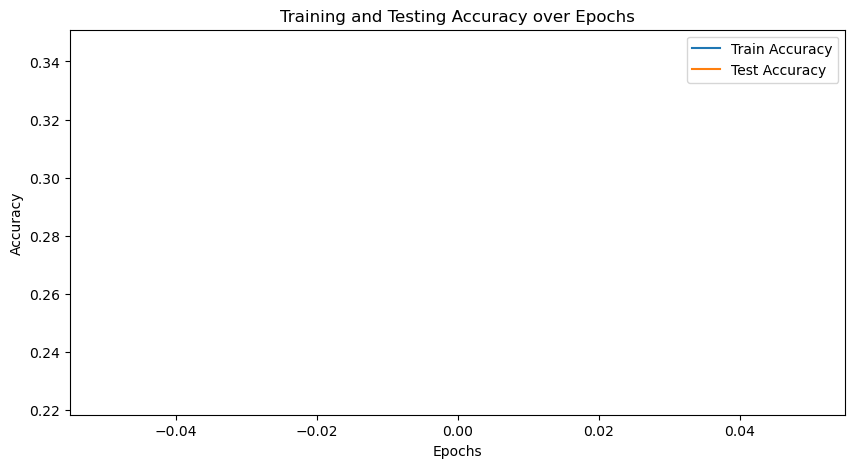

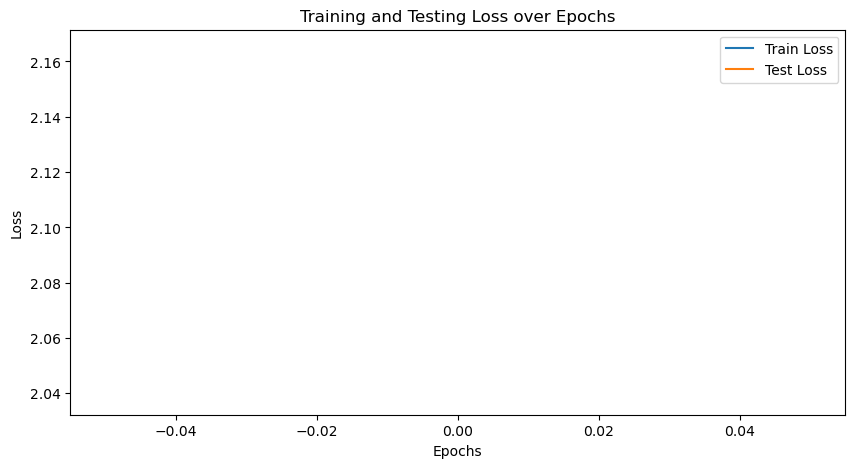

In [ ]:

# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.plot(results["train_acc"], label='Train Accuracy')
plt.plot(results["test_acc"], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

# Plot for loss
plt.figure(figsize=(10, 5))
plt.plot(results["train_loss"], label='Train Loss')
plt.plot(results["test_loss"], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

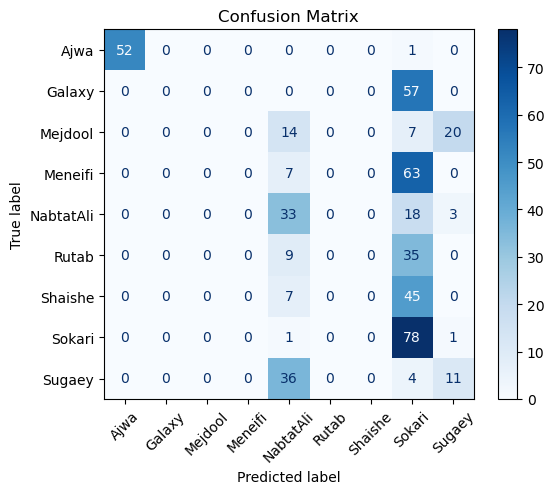

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()

# Initialize lists to store true labels and predictions
all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels to the lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

        Ajwa       1.00      0.98      0.99        53
      Galaxy       0.00      0.00      0.00        57
     Mejdool       0.00      0.00      0.00        41
     Meneifi       0.00      0.00      0.00        70
   NabtatAli       0.31      0.61      0.41        54
       Rutab       0.00      0.00      0.00        44
     Shaishe       0.00      0.00      0.00        52
      Sokari       0.25      0.97      0.40        80
      Sugaey       0.31      0.22      0.26        51

    accuracy                           0.35       502
   macro avg       0.21      0.31      0.23       502
weighted avg       0.21      0.35      0.24       502



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!mlflow ui

[2024-11-08 21:29:16 +0300] [8136] [INFO] Starting gunicorn 23.0.0
[2024-11-08 21:29:16 +0300] [8136] [INFO] Listening at: http://127.0.0.1:5000 (8136)
[2024-11-08 21:29:16 +0300] [8136] [INFO] Using worker: sync
[2024-11-08 21:29:16 +0300] [8137] [INFO] Booting worker with pid: 8137
[2024-11-08 21:29:16 +0300] [8138] [INFO] Booting worker with pid: 8138
[2024-11-08 21:29:16 +0300] [8139] [INFO] Booting worker with pid: 8139
[2024-11-08 21:29:16 +0300] [8140] [INFO] Booting worker with pid: 8140
^C
[2024-11-08 21:43:04 +0300] [8136] [INFO] Handling signal: int
[2024-11-08 21:43:04 +0300] [8138] [INFO] Worker exiting (pid: 8138)
[2024-11-08 21:43:04 +0300] [8137] [INFO] Worker exiting (pid: 8137)
[2024-11-08 21:43:04 +0300] [8140] [INFO] Worker exiting (pid: 8140)
[2024-11-08 21:43:04 +0300] [8139] [INFO] Worker exiting (pid: 8139)
